### NN Vector Pull for Direction

Jan 17 2024
TJ Kim

##### Summary
Load any NN model. Obtain layer by layer the unit direction vector (against vector of zeros). See if cosine similarity can be used as a metric to measure direction. Previously this was done to overfit a FAT model and push it towards FedAvg model. Now, the goal is to perform adversarial training on a FedAvg model to pull towards FAT model.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 163.46it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:36<00:00,  2.22it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


In [4]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [5]:
# Find mag norm 
mag_norm_FAT2FedAvg = []
for key in desired_keys: #params_FAT:

    diff =  params_FedAvg[key] - params_FAT[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FAT2FedAvg += [diff/torch.norm(diff,p=2)]


In [20]:
# Perform 50 rounds of FAT on FedAvg model 
num_rounds = 50
setting, num_user = "FedAvg_adv", 40


test_acc_gather = []
adv_acc_gather = []
cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

save_path_FedAvg_150R = 'weights/cifar10/240117_FedAvg150round/FedAvg/'

aggregator, clients, args_ = set_args(setting, num_user)

# Test performance of aggregator on data 
aggregator.load_state(dir_path = save_path_FedAvg_150R)
aggregator.update_clients()
model_FA = pull_model_from_agg(aggregator)
model_FA.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FA)

prev_model = copy.deepcopy(model_FA)

print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
test_acc_gather+= [np.mean(acc)]
adv_acc_gather += [np.mean(adv_acc)]

# Setting evasion attack parameters
x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
atk_params = PGD_Params()
atk_params.set_params(batch_size=1, iteration = 10,
                target = -1, x_val_min = x_min, x_val_max = x_max,
                step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)

adv_update_rnd_freq = 10

for i in range(num_rounds):

    # Per round Freq
    if i%adv_update_rnd_freq == 0:
        print("updating adv data set")
        # add adv dataset update
        G = 0.5
        Fu = np.ones(num_user) * G

        # Assign proportion and attack params
        for c in range(len(clients)):
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()
            aggregator.clients[c].assign_advdataset()

    aggregator.mix()
    model_overfit = pull_model_from_agg(aggregator)
    model_overfit.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_overfit)

    diffnn = get_diff_NN(prev_model, model_overfit, desired_keys)

    cosine_gather_layers[i,:] = diff_cosine_similarity(diffnn, mag_norm_FAT2FedAvg, len(desired_keys))
    print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    prev_model = copy.deepcopy(model_overfit)
    # Perform gradient direction gathering

==> Clients initialization..
===> Building data iterators..


100%|██████████| 80/80 [00:00<00:00, 218.22it/s]


===> Initializing clients..


100%|██████████| 80/80 [00:33<00:00,  2.39it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


Test acc:  0.8125 adv acc:  0.012500000186264515
updating adv data set
round 0 Test acc:  0.699999988079071 adv acc:  0.0625
round 1 Test acc:  0.737500011920929 adv acc:  0.17499999701976776
round 2 Test acc:  0.75 adv acc:  0.17499999701976776
round 3 Test acc:  0.7875000238418579 adv acc:  0.1875
round 4 Test acc:  0.800000011920929 adv acc:  0.1875
round 5 Test acc:  0.8125 adv acc:  0.20000000298023224
round 6 Test acc:  0.8125 adv acc:  0.1875
round 7 Test acc:  0.8125 adv acc:  0.1875
round 8 Test acc:  0.8125 adv acc:  0.1875
round 9 Test acc:  0.8125 adv acc:  0.1875
updating adv data set
round 10 Test acc:  0.7750000357627869 adv acc:  0.17499999701976776
round 11 Test acc:  0.7750000357627869 adv acc:  0.20000000298023224
round 12 Test acc:  0.7750000357627869 adv acc:  0.1875
round 13 Test acc:  0.7750000357627869 adv acc:  0.20000000298023224
round 14 Test acc:  0.7875000238418579 adv acc:  0.22500000894069672
round 15 Test acc:  0.7875000238418579 adv acc:  0.200000002980

In [21]:
diff_cosine_similarity(diffnn, mag_norm_FAT2FedAvg, len(desired_keys)).shape

(158,)

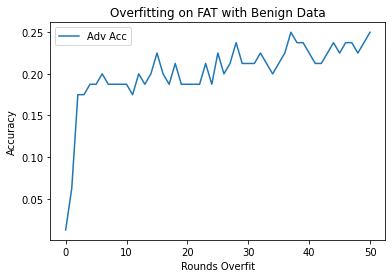

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = range(len(test_acc_gather))  # 100 points from 0 to 10
y1 = test_acc_gather               # Sine function for the first line
y2 = adv_acc_gather             # Cosine function for the second line

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
plt.plot(x, y2, label='Adv Acc')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Accuracy')
plt.title('Overfitting on FAT with Benign Data')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


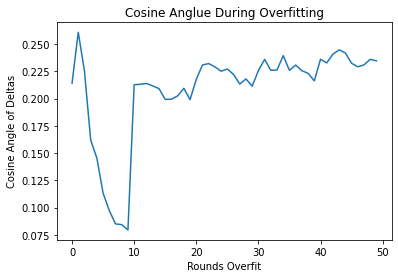

In [23]:
np.mean(cosine_gather_layers,axis = 1)

import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
y1 = np.mean(cosine_gather_layers,axis = 1)
x = range(len(y1))  # 100 points from 0 to 10


# Plotting the lines
plt.plot(x, y1, label='Cosine Angle')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Cosine Angle of Deltas')
plt.title('Cosine Anglue During Overfitting')

# Adding a legend
# plt.legend()

# Display the plot
plt.show()


In [24]:
cosine_gather_layers[:,10]

array([0.71, 0.67, 0.58, 0.57, 0.56, 0.63, 0.50, 0.50, 0.56, 0.50, 0.45,
       0.38, 0.41, 0.38, 0.36, 0.36, 0.35, 0.32, 0.31, 0.30, 0.35, 0.39,
       0.40, 0.36, 0.37, 0.36, 0.36, 0.34, 0.34, 0.34, 0.36, 0.39, 0.44,
       0.42, 0.45, 0.44, 0.43, 0.41, 0.44, 0.42, 0.49, 0.52, 0.53, 0.54,
       0.53, 0.54, 0.53, 0.55, 0.54, 0.50])

In [25]:
# Get number of params per desired key
size = np.zeros(len(desired_keys))
i = 0
for key in desired_keys:
    size[i]=params_FAT[key].flatten().shape[0]
    i += 1

prop = size/np.sum(size)

cosine_propped = np.zeros(cosine_gather_layers.shape)

# for t in range(num_rounds):
#     cosine_propped[t,:] = np.average(cosine_gather_layers[t,:], weights = prop)

np.average(cosine_gather_layers, weights = prop, axis = 1)

array([0.12, 0.14, 0.10, 0.06, 0.06, 0.05, 0.04, 0.04, 0.04, 0.04, 0.09,
       0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10,
       0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10,
       0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11,
       0.11, 0.11, 0.11, 0.11, 0.11, 0.11])

In [26]:
np.average(cosine_gather_layers[5], weights = prop)

0.04939374553427972

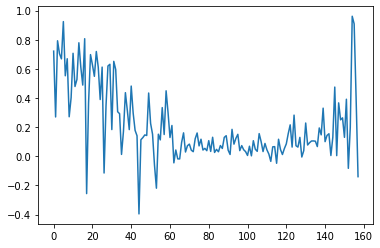

In [27]:
plt.plot(cosine_gather_layers[0])